## Welcome to the first-ever (and hopefully last-ever) remote ADA final exam (Fall 2020)

In this exam, you will analyze data from Wikipedia and from the [Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) game, which you have already encountered in lecture 12 on [“Handling networks”](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_92). The rules of the Wikispeedia game are simple:
1. Players are given two Wikipedia articles: a *source* and a *target*.
2. Starting from the source article, the goal is to reach the target, exclusively by following links in the articles encountered along the path.

### The data

The Wikispeedia data comprises ~76K games by human players, thereby capturing human navigation behavior on a very small subset of English Wikipedia comprising ~4.5K articles with a total of ~120K links between them.

The dataset is available in the `data` directory pushed to the same GitHub repo as the exam. Inside the data directory, you will find four files:

####  1. `article_df_task-A.tsv.gz`: A tab-separated file with the following information about Wikipedia articles
- *name*: The name of the Wikipedia article
- *topic*: The top-level topic label for the article (each article is assigned exactly one topic label)
- *content*: The cleaned text of the article (having removed punctuations, stopwords, numbers, and letter casing). It is stored as a space-separated string.

#### 2. `links_task-B.tsv.gz`: A tab-separated file containing Wikipedia links
- *linkSource*: The name of the source Wikipedia article from which the link originates
- *linkTarget*: The name of the target Wikipedia article to which the link points

#### 3.  `paths_df_task-B.tsv.gz`: A tab-separated file with the following information about the played games
- *hashed_ip_address*: Anonymized IP address of the player
- *source*: The name of the Wikipedia article from where the game started
- *target*: The name of the target article that the player was supposed to reach 
- *finished*: Whether the game was successfully finished (whether the player reached the target article)
- *human_path_length*: The number of clicks made by the player, before they either reached the target (in *finished* games) or gave up (in *unfinished* games)
- *shortest_path_length*: The minimum number of clicks required to reach the target article from the source article. Disconnected source-target article pairs have a shortest_path_length of *-1*.
- *duration_in_sec*: The duration of the game in seconds

#### 4.  `paths_df_task-C.tsv.gz`: In continuation to the task-B paths dataframe, this tab-separated file has the following additional information
- *in_degree_target*: In-degree of the target article, that is the number of incoming links that lead to the target article

*Note: In all the aforementioned files, the first line contains the header information. Additionally, article names are URL-encoded. For example, 'Antonín_Dvořák' is stored as 'Anton%C3%ADn_Dvo%C5%99%C3%A1k'. If needed, you can decode the article names using this code: `from urllib.parse import unquote; unquote('article-name')`.*

In [1]:
''' Some minimalistic imports '''
import pandas as pd
import random
import gzip
import operator
import time
from urllib.parse import unquote

import numpy as np
import scipy.stats as stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, balanced_accuracy_score

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Task A. Can we predict article topic using textual content?

*Note-1: For the entire Task A, we will use logistic regression for its scalability and simplicity. Specifically, we will use [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) available in `sklearn` with 'log' loss and '5' epochs for training a logistic regression classifier.*

*Note-2: In all the cases where random number generation is required (train-test split, fitting the model, etc.), make sure to use 42 as the random seed.*

### A1. Load the text data and analyze the topic distribution
1. Load `data/article_df_task-A.tsv.gz` as a pandas dataframe.   
   *Note: we have already cleaned the text for you!*
2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

In [2]:
'''your code here''';
articles_content = pd.read_csv('data/article_df_task-A.tsv.gz', sep="\t", compression='gzip')

Total number of unique topics are:  14


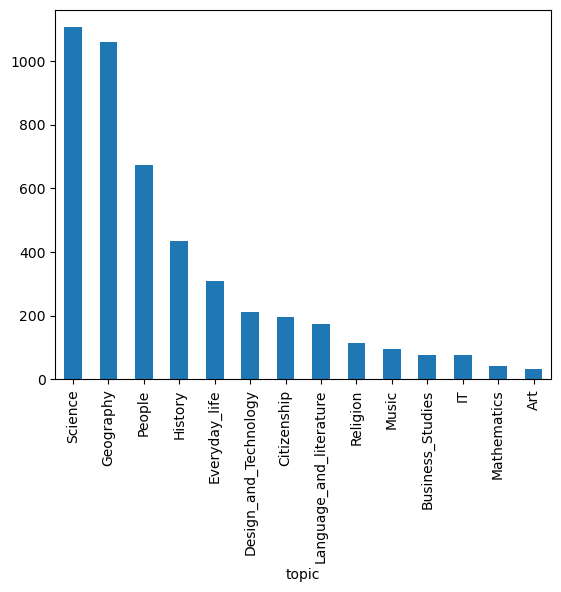

In [3]:
topic_dist = articles_content['topic'].value_counts()
print("Total number of unique topics are: ", len(topic_dist))
topic_dist.plot(kind='bar')
plt.show()

**Answering A1.2:**   
There is a substantial disparity in topic frequency of different topics. Certain topics such as 'Science' and 'Geography' are highly frequent, while others such as 'Mathematics' and 'Art' are super rare.

### A2. Topic classification (multi-class): Articles from 5 most frequent topics

#### A2.1 Prepping the data for ML
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

#### A2.2 Train and evaluate a multi-class classifier
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

In [4]:
'''your answer/code here''';
top5 = list(topic_dist.index)[0:5]
top5_articles_content = articles_content.loc[articles_content['topic'].apply(lambda x: x in top5)].copy()
'''
another way
top5_articles_content = articles_content.loc[articles_content['topic'].isin(top5)].copy()
'''
factor = pd.factorize(top5_articles_content['topic'])
top5_articles_content['labels'] = factor[0]
top5_definitions = factor[1]
print(top5_definitions)
top5_articles_content.head()

Index(['People', 'Geography', 'History', 'Science', 'Everyday_life'], dtype='object')


,name,topic,content,labels
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,copyright aedan mac gabrain schools wikipedia ...,0
1,%C3%85land,Geography,copyright aland schools wikipedia selection re...,1
2,%C3%89douard_Manet,People,copyright edouard manet schools wikipedia sele...,0
3,%C3%89ire,Geography,copyright eire schools wikipedia selection rel...,1
4,%C3%93engus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...,0


In [5]:
X = top5_articles_content['content'].to_numpy()
y = top5_articles_content['labels'].to_numpy()
print(X)

['copyright aedan mac gabrain schools wikipedia selection related subjects british history including roman britain historical figures satellite image northern britain ireland showing approximate area dal riata shaded enlarge satellite image northern britain ireland showing approximate area dal riata shaded aedan mac gabrain king dal riata kingdom modern argyll scotland county antrim ireland onwards contemporary columba recorded life career comes hagiography adomnan iona life saint columba irish annals record aedan campaigns neighbours ireland northern britain including expeditions orkney islands isle man north east scotland recorded bede aedan decisively defeated æthelfrith bernicia battle degsastan aedan deposed abicated following defeat died background sources aedan life include bede historia ecclesiastica gentis anglorum irish annals principally annals ulster annals tigernach adomnan life saint columba aedan appears character early irish works gein branduib maic echach ocus aedain m

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters = {
    'clf__alpha': [1e-4],    
}

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', loss='log_loss', max_iter=5, tol=None, random_state=42))
])

tstart = time.time()
gs_clf = GridSearchCV(text_clf, parameters, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)
tend = time.time()
print(tend-tstart)

12.064048051834106


In [7]:
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8778912294932049
clf__alpha: 0.0001


In [8]:
predicted = gs_clf.predict(X_test)
print("Accuracy on Test Data: ", np.mean(predicted == y_test))

Accuracy on Test Data:  0.88268156424581


**Answering A2.2.4:**   
In a 5-class classification a random model obtains an accuracy of 20% in expectation. Thus, obtaining an accuracy in high 80s is a strong outcome.

### A3. Topic classification (binary): Articles from the most and least frequent topics

#### A3.1 Train and evaluate a binary classifier
1. Restrict the data to articles belonging to the most frequent or to the least frequent topic.
2. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).
3. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
4. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.
5. Report the classifier performance on the test data using accuracy as the metric.

In [9]:
'''your answer/code here''';
top_and_bottom = list(topic_dist.index)[::len(list(topic_dist.index))-1]
top_and_bottom_articles_content = articles_content.loc[articles_content['topic'].apply(lambda x: x in top_and_bottom)].copy()
'''
another way
top_and_bottom_articles_content = articles_content.loc[articles_content['topic'].isin(top_and_bottom)].copy()
'''
factor = pd.factorize(top_and_bottom_articles_content['topic'])
top_and_bottom_articles_content['labels'] = factor[0]
top_and_bottom_definitions = factor[1]
print(top_and_bottom_definitions)
top_and_bottom_articles_content.head()

Index(['Science', 'Art'], dtype='object')


,name,topic,content,labels
13,16_Cygni,Science,copyright cygni schools wikipedia selection re...,0
14,16_Cygni_Bb,Science,copyright cygni bb schools wikipedia selection...,0
25,1_Ceres,Science,copyright ceres dwarf planet schools wikipedia...,0
41,3_Juno,Science,copyright juno schools wikipedia selection rel...,0
46,47_Ursae_Majoris,Science,copyright ursae majoris schools wikipedia sele...,0


In [10]:
X_small = top_and_bottom_articles_content['content'].to_numpy()
y_small = top_and_bottom_articles_content['labels'].to_numpy()

In [11]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

parameters = {
    'clf__alpha': [1e-4],
}

text_clf_small = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', loss='log_loss', max_iter=5, tol=None, random_state=42))
])

tstart = time.time()
gs_clf_small = GridSearchCV(text_clf_small, parameters, cv=5)
gs_clf_small = gs_clf_small.fit(X_train_small, y_train_small)
tend = time.time()
print(tend-tstart)

2.4055495262145996


In [12]:
print(gs_clf_small.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf_small.best_params_[param_name]))

0.9824056603773584
clf__alpha: 0.0001


In [13]:
predicted_small = gs_clf_small.predict(X_test_small)
print("Accuracy on Test Data: ", np.mean(predicted_small == y_test_small))

Accuracy on Test Data:  0.9707602339181286


#### A3.2 Assessing the evaluation metric
1. **/Discuss:/** What is your take on the accuracy obtained in A3.1? Do you think accuracy is the correct evaluation metric for this task? If yes, justify! If not, why not, and what else can be used?
2. If you included additional evaluation metrics in A3.2.1, then perform an empirical analysis of the performance using these metrics.   
   **/Discuss:/** Additionally, discuss what you observe. Is it harder to predict the topic labels of certain articles? Why, or why not? Please elaborate!

**Answering A3.2.1**   
There is a huge class imbalance, thus, accuracy is not a good metric. It is very easy for accuracy to be biased. If you label everything as the majority class, the accuracy would still be very high (in the high 90s), but the performance on the minority class would be terrible.

In such cases, one can use the either of the following for evaluation.
1. confusion matrix, 
2. balanced accuracy score (sklearn), or 
3. (un)weighted micro/macro averaged F1 scores

**Answering A3.2.2**   
It is hard to correctly predict the topic labels of the articles in the minority class. This could be because of the following reasons:
1. The model didn't see enough training data from the minority class to learn to classify/discriminate it.
2. The loss function treats each training sample as equally important. Thus, trying to minimize the overall loss would  guide the model to focus more on the majority class.

#### At least one of the following should be be used to report the performance. If a reasonable alternate metric is suggested, judge based on it's correctness!

In [14]:
print(confusion_matrix(y_test_small, predicted_small))

[[329   1]
 [  9   3]]


In [15]:
print(balanced_accuracy_score(y_test_small, predicted_small))

0.6234848484848485


In [16]:
print(classification_report(y_test_small, predicted_small, digits=3))

              precision    recall  f1-score   support

           0      0.973     0.997     0.985       330
           1      0.750     0.250     0.375        12

    accuracy                          0.971       342
   macro avg      0.862     0.623     0.680       342
weighted avg      0.966     0.971     0.964       342



#### A3.3 Class proportions
1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, justify the reasons behind your choice.   
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*
2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
    * Lastly, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

**Answering A3.3.1**   
As evident from the confusion matrix, the disparity in class proportions does indeed hurt the model. Almost all (99%) of the examples are classified as class 0. What's more, 75% of the articles in class 1, are predicted to belong to class 0.

One way to address this is to employ cost-sensitive learning, i.e., using `class-weight`='balanced' while training the model. Another way could be up/down sampling minority/majority class. 'SMOTE' is a very popular technique of oversampling the minority class that can be employed here.

The solution described below uses `class-weight`='balanced', however, if someone uses 'SMOTE' that's acceptable as well.

**A3.3.2**

In [19]:
parameters = {
    'clf__alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
}

text_clf_small = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', loss='log_loss', max_iter=5, tol=None, random_state=42, class_weight='balanced'))
])

tstart = time.time()
gs_clf_small = GridSearchCV(text_clf_small, parameters, cv=5)
gs_clf_small = gs_clf_small.fit(X_train_small, y_train_small)
tend = time.time()
print(tend-tstart)

12.96419620513916


In [20]:
print(gs_clf_small.best_score_)
for param_name in sorted(parameters.keys()):
    print("The optimal %s is: %r" % (param_name, gs_clf_small.best_params_[param_name]))

0.9987421383647799
The optimal clf__alpha is: 0.01


In [21]:
predicted_small = gs_clf_small.predict(X_test_small)
print("Accuracy on Test Data: ", np.mean(predicted_small == y_test_small))

Accuracy on Test Data:  0.9941520467836257


#### Similar to A3.2, at least one of the following should be be used to report the performance. If a reasonable alternate metric is suggested, judge based on it's correctness!

In [22]:
print(confusion_matrix(y_test_small, predicted_small))

[[329   1]
 [  1  11]]


In [23]:
print(balanced_accuracy_score(y_test_small, predicted_small))

0.9568181818181818


In [24]:
print(classification_report(y_test_small, predicted_small, digits=3))

              precision    recall  f1-score   support

           0      0.997     0.997     0.997       330
           1      0.917     0.917     0.917        12

    accuracy                          0.994       342
   macro avg      0.957     0.957     0.957       342
weighted avg      0.994     0.994     0.994       342



**Ansering A3.3.2**   
The results are much better now as both the minority and majoirty classes are properly classified. This is evident from the confusion matrix, balanced accuracy score, or macro averaged f1-score.

Using 'balanced' class weights while training the model forces the loss function to give higher relative importance to training samples corresponding to the minority class. Actually, the training samples are weighted as inverse of the class proportions.

### A4. Revisiting Multi-class classifier of A2.2

1. Print and analyze the confusion matrix for the multi-class model trained in A2.2. **/Discuss:/** What do you observe?
2. **/Discuss:/** Similar to A3.3, does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, justify the reasons behind your choice.
3. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A5**.
    * Implement the fix you proposed in A4.2, and repeat the classification task performed in Step A2.2 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 2 minutes of compute time.*
    * Lastly, obtain the accuracy and confusion matrix.
4. **/Discuss:/** Contrast the confusion matrix obtained in A4.1 with the one obtained in A4.3. Do you observe any differences? Why, or why not? Please elaborate!

In [25]:
'''your answer/code here''';
print(confusion_matrix(y_test, predicted))

[[182   3  11   3   1]
 [  1 297   2  17   0]
 [ 26  14  86   3   0]
 [  3   0   0 327   0]
 [ 13   5   1  23  56]]


#### The following two metrics are not required/mandatory per the question!

In [26]:
print(balanced_accuracy_score(y_test, predicted))

0.8151825692708974


In [27]:
print(classification_report(y_test, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.809     0.910     0.856       200
           1      0.931     0.937     0.934       317
           2      0.860     0.667     0.751       129
           3      0.877     0.991     0.930       330
           4      0.982     0.571     0.723        98

    accuracy                          0.883      1074
   macro avg      0.892     0.815     0.839      1074
weighted avg      0.888     0.883     0.877      1074



**Answering A4.1**   
The two least frequent classes have a much higher error than the other three more frequent classes. In fact, the error is somewhat inversely correlated with the frequency of the class. The higher the frequency the lesser the error.

**Answering A4.2**   
As evident from the confusion matrix, the disparity in class proportions does indeed hurt the model.

One way to address this is to employ cost-sensitive learning, i.e., using `class-weight`='balanced' while training the model. Another way could be up/down sampling minority/majority class. 'SMOTE' is a very popular technique of oversampling the minority class that can be employed here.

The solution described below uses `class-weight`='balanced', however, if someone uses 'SMOTE' that's acceptable as well.

In [28]:
parameters = {
    'clf__alpha': [1e-3, 1e-4, 1e-5, 1e-6],
}

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(penalty='l2', loss='log_loss', max_iter=5, tol=None, random_state=42, class_weight='balanced'))
])

tstart = time.time()
gs_clf = GridSearchCV(text_clf, parameters, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)
tend = time.time()
print(tend-tstart)

42.40356183052063


In [29]:
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("The optimal %s is: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8946497443360292
The optimal clf__alpha is: 1e-05


In [30]:
predicted = gs_clf.predict(X_test)
print("Accuracy on Test Data: ", np.mean(predicted == y_test))

Accuracy on Test Data:  0.8966480446927374


In [31]:
print(confusion_matrix(y_test, predicted))

[[178   1  16   3   2]
 [  2 295   5  14   1]
 [ 25   7  96   1   0]
 [  5   1   0 322   2]
 [  7   4   1  14  72]]


#### The following two metrics are not required/mandatory per the question!

In [32]:
print(balanced_accuracy_score(y_test, predicted))

0.8550473737810795


In [33]:
print(classification_report(y_test, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.890     0.854       200
           1      0.958     0.931     0.944       317
           2      0.814     0.744     0.777       129
           3      0.910     0.976     0.942       330
           4      0.935     0.735     0.823        98

    accuracy                          0.897      1074
   macro avg      0.887     0.855     0.868      1074
weighted avg      0.898     0.897     0.895      1074



**Answering A4.4**   
The results are much better now: the two low frequency classes are now better classified. This is evident from the confusion matrix, balanced accuracy score, or macro averaged f1-score.

Using 'balanced' class weights while training the model forces the loss function to give higher relative importance to training samples corresponding to the classes with lower frequency. Actually, the training samples are weighted as inverse of the class proportions.

### A5. Interpretability
1. For each of the 5-classes considered in **A4**, obtain a list of top-10 words (sorted in descending order of their importance) based on the feature weights learned by the classifier.

2. **/Discuss:/** Qualitatively discuss the relevance of the identified words and their association with the respective class-labels. Is the classifier correct to assign them high weights? Are they truly discriminative/predictive of the respective class-labels? Justify your responses with clear and crisp reasons!

In [34]:
'''your answer/code here''';
top5_coeff_indices = np.argsort(gs_clf.best_estimator_.named_steps['clf'].coef_)[:,-10:][:,::-1]
print(top5_definitions)
np.array(gs_clf.best_estimator_.named_steps['vect'].get_feature_names())[top5_coeff_indices]

Index(['People', 'Geography', 'History', 'Science', 'Everyday_life'], dtype='object')


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

**Answering A5.2**   
It is quite clear that the top-10 words are discriminative/predictive of the corresponding class-labels.   
For example, 'life', 'death', 'work', 'born', 'career' are quite highly associated with the 'people' class, which is intuitive.   
Similarly, 'roman', 'war', 'empire', 'century' being associated with 'history' class is also quite intuitive.   
Also, similar points can be said about the other classes as well!

# Task B. The Wikipedia link network

### B1. Wikipedia network: reveal your shape!
#### B1.1 Load the Wikipedia link network (`data/links_task-B.tsv.gz`) into memory as a directed graph using `NetworkX`.
1. Compute the following from the loaded graph object:
    * the number of nodes,
    * the number of edges, and
    * the average degree.
2. **/Discuss:/** In order to summarize the degree distribution in a single number, would you recommend using the average degree? Why, or why not? If not, what alternatives can you think of? Please elaborate!

In [35]:
'''your answer/code here''';
flinks = gzip.open("data/links_task-B.tsv.gz")
edgeList = []; nodes = {}; edges = {}
idx = 0
for line in flinks:
    line = line.decode('utf-8').strip()
    if idx==0 or '#' in line or len(line)==0:
        idx+=1
        continue
    line = line.split("\t")
    source = line[0]; target = line[1]
    nodes[source] = True; nodes[target] = True
    edges[(source,target)] = True
    edgeList.append((source,target))
    idx+=1
    
G = nx.DiGraph()
G.add_edges_from(edgeList)
print(len(G.nodes()), len(G.edges()), len(G.edges())/len(G.nodes()))

4592 119882 26.10670731707317


**Answering B1.1.2**   
Average degree is not recommended as the degree distribution of real-world networks usually follows a powerlaw. Summarizing powerlaws with average values is not a good idea, as there is a long tail, and there are many nodes that have very high degree. Instead, median is a better choice.

#### B1.2 Using the appropriate plot type, plot the in-degree and out-degree distributions of the Wikipedia link network and analyze it. 
1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.

In [38]:
'''your answer/code here''';
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


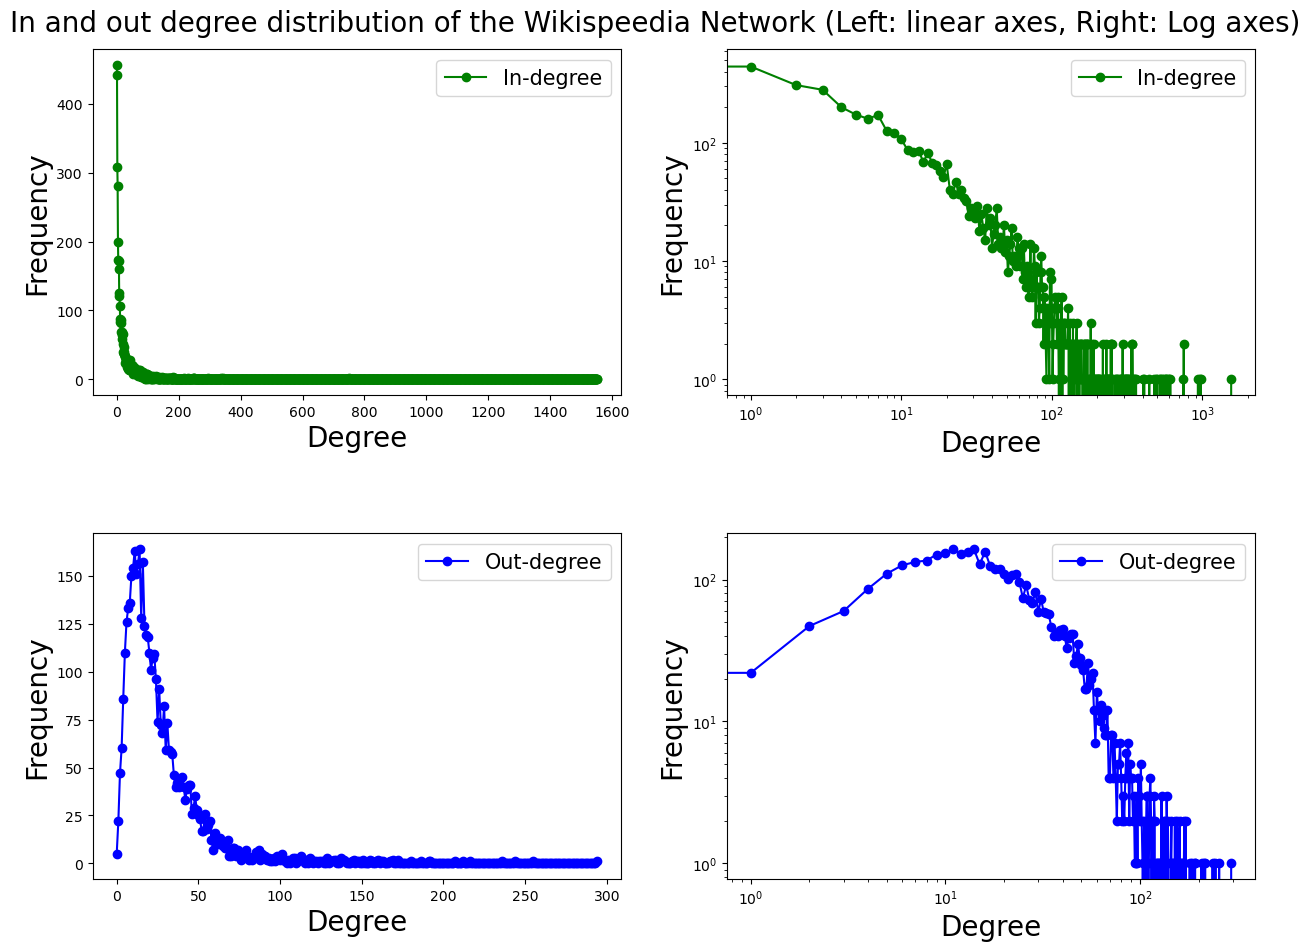

In [37]:
in_degree_freq = degree_histogram_directed(G, in_degree=True)
out_degree_freq = degree_histogram_directed(G, out_degree=True)
degrees = range(len(in_degree_freq))
fig, axes = plt.subplots(2, 2, figsize = (15,10),gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
fig.suptitle("In and out degree distribution of the Wikispeedia Network (Left: linear axes, Right: Log axes)", fontsize=20)
axes[0][0].plot(range(len(in_degree_freq)), in_degree_freq, 'go-', label='In-degree')
axes[0][1].loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='In-degree') 
axes[1][0].plot(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='Out-degree')
axes[1][1].loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='Out-degree')
for x in range(0,axes.shape[0]):
    for y in range(0,axes.shape[1]):
        axes[x,y].set_xlabel('Degree', fontsize = 20)
        axes[x,y].set_ylabel('Frequency', fontsize = 20)
        axes[x,y].legend(fontsize=15)
fig.subplots_adjust(top=0.94)
plt.show()

**B1.2.1** Appropriate scale is log-log.   
**B1.2.2** distribution follows powerlaw, linear in the log-log plot.

#### B1.3 Connectedness of the Wikipedia link network

**Definition-1:** An undirected graph $G$ is said to be connected if, for every pair of vertices $(u, v)$, it contains a path that connects the two vertices.

**Definition-2:** A directed graph $G_{dir}$ is **weakly connected** (or simply connected) if the underlying undirected graph obtained by replacing all directed edges of the graph with undirected edges is a connected graph (cf. Definition-1). 

**Definition-3:** A directed graph $G_{dir}$ is **strongly connected** if, for every pair of vertices $(u, v)$, it contains a directed path from $u$ to $v$ and a directed path from $v$ to $u$.

Given these definitions, what can you say about the connectedness of the Wikipedia link network? Specifically, answer the following:
1. Is the Wikipedia link network weakly connected? If not, print the number of weakly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest weakly connected component.
2. Is the Wikipedia link network strongly connected? If not, print the number of strongly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest strongly connected component.

In [39]:
'''your answer/code here''';
print("Weakly connected: ", nx.is_weakly_connected(G))
print(f"There are {len(list(nx.weakly_connected_components(G)))} weakly connected components")
print("Strongly connected: ", nx.is_strongly_connected(G))
print(f"There are {len(list(nx.strongly_connected_components(G)))} strongly connected components")

Weakly connected:  False
There are 2 weakly connected components
Strongly connected:  False
There are 519 strongly connected components


In [40]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(list(largest_cc))
print(len(H.nodes()), len(H.edges()), len(H.edges())/len(H.nodes()))

4589 119879 26.123120505556766


In [41]:
largest_scc = max(nx.strongly_connected_components(G), key=len)
H = G.subgraph(list(largest_scc))
print(len(H.nodes()), len(H.edges()), len(H.edges())/len(H.nodes()))

4051 111900 27.6228091829178


### B2. The interplay between human navigation behavior and Wikipedia network structure

#### B2.1 Loading and analyzing the game data (3 points)
1. Load `data/paths_df_task-B.tsv.gz` as a pandas dataframe.
2. Some games were successfully finished (*finished=True*) while others were unsuccessful (i.e., the player gave up before reaching the target article). However, not all unsuccessful games are infeasible; the player might simply not have been good enough at the game to reach the target from the source. **/Discuss:/** Clearly state the reasons why there may be games that are *truly infeasible*.   
3. List all unsuccessful games that are *truly infeasible* and remove them from the dataframe.

**Answering B2.1.2**   
It's impossible to reach a target for games where there is no path existent between the source and the target in the underlying graph, indicated by the shortest_path_length of -1

In [42]:
'''your answer/code here''';
paths = pd.read_csv('data/paths_df_task-B.tsv.gz', sep="\t", compression='gzip')
paths[paths['shortest_path_length'] == -1]

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec
53533,4c03b8fb18fc9752,Oasis_%28band%29,Final_Fantasy_%28video_game%29,False,1,-1,13
56880,3af13b307343dec9,Adolf_Hitler,The_Frogs,False,6,-1,1874
63647,093e40d06992b8dc,Anne_Frank,Final_Fantasy_%28video_game%29,False,21,-1,519
63648,093e42416992ba4d,Anne_Frank,Final_Fantasy_%28video_game%29,False,21,-1,542
64511,17ef27577d43939d,Toy,Lego,False,1,-1,1807
66654,5e55877267bd6864,Hymenoptera,Portuguese_Communist_Party,False,8,-1,264
71566,3d9b105c56bcf38a,Private_Peaceful,Unix,False,1,-1,1804
75567,360d256e3fd2a746,Quantum_mechanics,Blue_Tit,False,15,-1,2464


In [43]:
paths = paths.loc[paths['shortest_path_length'] != -1]

#### B2.2 Wikispeedia => Wikislowia?
1. Compute and report the average and median path lengths for games that were successfully finished (*finished=True*). You should compute and report path length in two ways: (1) with respect to the number of clicks needed by *human players*, (2) with respect to the *minimum* number clicks an *optimal player* would need.   
   **/Discuss:/** What can you say about the navigability of the Wikipedia link network?   
   *Hint: Think about [Milgram's experiment](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_261) and relate your findings with his findings!*
2. **/Discuss:/** Suppose you want to maliciously decrease Wikipedia's navigability. You are allowed to remove certain edges in the network. What criterion would you use to decide which edges should be removed? Additionally, discuss why these edges are critical for Wikipedia's navigability. Justify your answer with clear and substantive reasoning!   
   _Hint: Navigability of a network depends on the existence of short paths in the network._
3. **/Discuss:/** In continuation to B2.2.2, assume you are given a budget of $k<<n$ edges to be removed. Design the algorithm that you would employ, provide its pseudocode (as a list of steps), and justify your algorithm design choice.   
   *Note: You don't have to describe the steps for computing the criterion you identified in Step B.2.2. Instead, using the identified criterion as a blackbox, you have to provide the steps required to remove $k>1$ edges.*

In [44]:
'''your answer/code here''';
paths[paths['finished']].describe()

,human_path_length,shortest_path_length,duration_in_sec
count,51314.000000,51314.000000,51314.000000
mean,6.757493,2.845500,158.281814
std,4.680779,0.700748,360.855130
min,1.000000,0.000000,0.000000
25%,5.000000,2.000000,60.000000
50%,6.000000,3.000000,107.000000
75%,8.000000,3.000000,183.000000
max,435.000000,6.000000,35091.000000


**Answering B2.2**
1. The average and median path length based on human navigation in the completed games is 6.75 and 6, respectively. Similar to the 6-degrees of separation results in Milgram's experiment! Also, avg and median shortest path lengths are 2.85 and 3, respectively, which shows that short paths do exist in the network, and the former result shows that they are discoverable by humans without knowledge of the overall network structure.
2. Find the edge with the highest edge betweenness centrality value. Removing such an edge would impact a lot of shortest paths, as the highest fraction of shortest paths pass through this edge.
3. Pseudocode: (Iterative greedy)
   Step-1: Find the edge with the highest betweenness centrality value.
   Step-2: Remove the edge.
   Step-3: Repeat Steps 1 and 2, until k edges have been removed.
   Note: Removing k-edges based on their betweenness centrality in one-go is not the best way to proceed, iterative greedy is better!

#### B2.3 Relationship between network structure and game completion
1. Enrich the dataframe with the in-degree and eigenvector centrality of the target article for each game path.
2. Using plots of appropriate type, plot the in-degree distribution of the target articles of game paths. What is the appropriate scale of the axes? Additionally, summarize the in-degree distribution of the target articles in a single number using a suitable metric. Justify your choice of the metric.
3. Using plots of appropriate type, analyze the differences in in-degree and eigenvector centrality of finished and unfinished games.   
   **/Discuss:/** What do you observe? Clearly discuss your observations!

In [45]:
'''your answer/code here''';
tstart = time.time()
eigenvector_centrality = pd.Series(dict(nx.algorithms.eigenvector_centrality(G)))
in_degree = pd.Series(dict(G.in_degree()))
df_cent = pd.DataFrame([eigenvector_centrality, in_degree]).T.rename({0: "eigenvector_centrality",
                                                                      1: "in_degree"}, axis=1)

paths["eigenvector_centrality_target"] = \
    paths.target.apply(lambda x: df_cent["eigenvector_centrality"][x] 
                      if x in df_cent["eigenvector_centrality"] else None)

paths["in_degree_target"] = \
    paths.target.apply(lambda x: df_cent["in_degree"][x] 
                      if x in df_cent["in_degree"] else None)

paths = paths.loc[~paths.in_degree_target.isna()]
tend = time.time()
print(tend - tstart)

1.4489691257476807


#### B2.3.2: Please note axes labels and titles should be added in the plots presented by the students. Also, we just truncated to max degree of 100 for ease of exposition, such thing is not expected from the students, and if done, should lead to reduction of the points. Also, plots similar to what I made in B1.2 are acceptable (in fact better), and even bar-charts are accepted.

(array([21645., 15117.,  7632.,  4869.,  6033.,  3211.,  2607.,  3660.,
         1546.,  1014.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

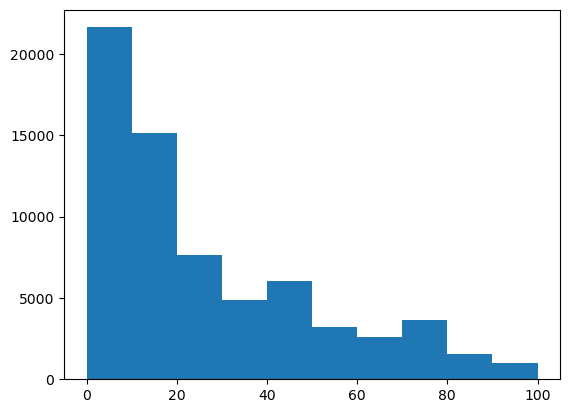

In [46]:
plt.hist(paths["in_degree_target"], range = [0,100])

In [47]:
print(paths["in_degree_target"].mean(), paths["in_degree_target"].median())

49.35447060522895 20.0


#### B2.3.3: Even in this scenario bar-charts are acceptable. More fundamentally, any plot that portrays the differences b/w finished and unfinished games for the said metrics (in-degree and eigenvector centrality) is acceptable!

<Axes: xlabel='finished', ylabel='in_degree_target'>

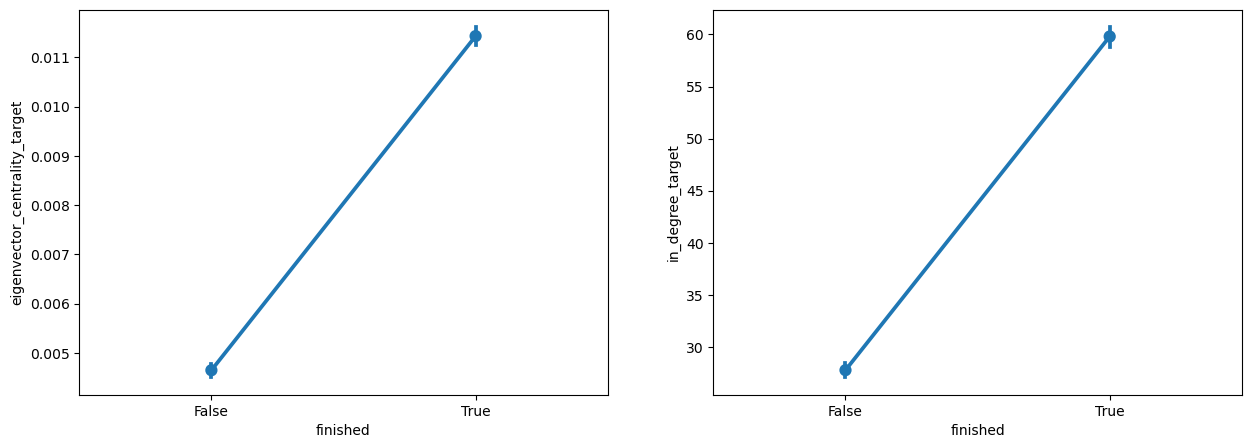

In [48]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.pointplot(x="finished", y="eigenvector_centrality_target", data=paths, ax=axs[0])
sns.pointplot(x="finished", y="in_degree_target", data=paths, ax=axs[1])

**Answering B2.3.3:**   
The average eigenvector centrality and in-degree of the end nodes is higher for games that were successfully finished when compared to those that weren't. This is an important signal, as it indicates that nodes with higher in-degree (resp. eigenvector centrality) are easier and better targets for human navigation (could result in shorter paths and faster game completion), which is quite intuitive.
It also hints towards the possibility of finding a causal effect, however, further exploration is needed to substantitate that assumption!

# Task C. Putting on the causality hat

### C1. Are articles with high in-degree easier to find? A naive analysis

Recall that in each Wikispeedia game, a player is **randomly** assigned a source article and a target article. In task **C**, we are interested in measuring the effect of the target article's in-degree on the player's chances of successfully finishing the game.

1. Load `data/paths_df_task-C.tsv.gz` as a pandas dataframe.
2. Consider target articles with fewer than 20 incoming links to have a *low in-degree* and articles with at least 20 to have a *high in-degree*.
3. Calculate the fraction of games with a high-in-degree target that was finished, and the fraction of games with a low-in-degree target that was finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
4. Repeat the same analysis for the game duration, for finished games only.
5. Quantify and discuss your findings from Steps C1.3 and C1.4.

In [49]:
'''your answer/code here''';
paths = pd.read_csv('data/paths_df_task-C.tsv.gz', sep="\t", compression='gzip')
paths["in_degree_binary_target"] = paths["in_degree_target"] >= 20

pfinish_high = (sum(paths.loc[paths["in_degree_binary_target"]].finished)/len(paths.loc[paths["in_degree_binary_target"]]))
pfinish_low = (sum(paths.loc[~paths["in_degree_binary_target"]].finished)/len(paths.loc[~paths["in_degree_binary_target"]]))

print(pfinish_high)
print(pfinish_low)
print(pfinish_high - pfinish_low)

time_high = paths.loc[(paths["in_degree_binary_target"])&paths['finished']].duration_in_sec.mean()
time_low = paths.loc[(~paths["in_degree_binary_target"])&paths['finished']].duration_in_sec.mean()

print(time_high)
print(time_low)
print(time_high - time_low)

0.777918813942271
0.5618646371296548
0.21605417681261618
130.42851548477628
199.57196071791398
-69.1434452331377


#### C1: Note that a statistical significance test (any meaningful test or bootstrapped CIs) is expected from students

**Answering C1:**   
Games with high in-degree targets are 21.61% more *likely to be finished*, and last 69.14 *seconds shorter* if finished.

### C2. Modeling the study setup with a causal diagram

**C2.1** We are interested in the effect of target in-degree (**deg(T)**) on the binary outcome (**O**) that captures whether the game was successfully finished or not. In the previously conducted naive analysis, we did not take into account the shortest path length (**L**), which is the minimum number of clicks necessary in order to reach the target article from the source article (**S**). Target and source articles are randomly assigned, independently from each other. The assigned source article S and deg(T) affect the shortest path length L. The source article affects the outcome through the shortest path length, and also directly, as some sources might be more central in the network. Choose a causal diagram **(A, B, C, D, E, or F)** that corresponds to the described relationships between the 4 variables:
- **deg(T):** target in-degree,
- **L:** shortest path length between source and target,
- **S:** name of source article,
- **O:** outcome, i.e., the binary indicator that says whether the game was successfully finished.

In [ ]:
Image(filename="img/diagram.png") 

**Answering C2.1** The correct causal diagram is presented in choice **B**.   

We can elimate C, E, F as there is a effect from T to S, which is not mentioned in the description.   
We can elimate D as there is a effect from L to S whereas the inverse is True.   
We can eliminate A as there is a effect from O to L, where as the inverse is True.

**C2.2** **/Discuss:/** What is potentially misleading about the naive analysis done in task **C1**? In what conceivable ways could the conclusions about the impact of target in-degree **deg(T)** on the outcome **O** be wrong?
Could the findings go in the opposite direction of a true direct causal effect? Justify your answer.

**Answering C2.2** In C1, we are not measuring the direct effect, but the total effect, including the effect mediated through the shortest path length. Possible answers: <br>
a) C1 is a very naive analysis, could come up with any confounder that could reverse the effect. <br>
b) Depending on on the strength and the sign of the mediated impact, since we are measuring the total impact, we could see different results compared to the true direct causal effect.

### C3. A more controlled analysis: matching on source article and shortest path length

Let's now understand how the estimated effect of the target in-degree would differ if we controlled for both the source article and the shortest path length between source and target. Construct a set of matched pairs of games. In a matched pair, the two games differ in target in-degree (one has a high in-degree, and the other has a low in-degree), but the source article and the shortest path length are exactly the same.

1. Perform exact matching on source article and shortest path length. This means that two candidate games can be matched only if the source article and the shortest path length are exactly the same.   
   **Important heads-up**: *Depending on the configuration of your computer, computing the exact matching could take up to 3 minutes of compute time.*
2. Among the matched pairs of games, calculate the fraction of games with a high-in-degree target that was successfully finished, and the fraction of games with a low-in-degree target that was successfully finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
3. **/Discuss:/** What do you observe? Are the conclusions different from the conclusions reached in C1? If yes, speculate as to why that is the case. How is the estimation in task C1 different from the estimation in task C3?
4. **/Discuss:/** Based on your findings, how should Wikipedia be modified in order to increase the fraction of finished Wikispeedia games?

*Hint: How you construct the set of matched pairs is up to you. One way can be to build an unweighted bipartite graph where games with targets with a high in-degree are on one side (the "treated class"), and games with targets with a low in-degree are on the other side (the "control class"). The edge between two matching candidate games is created only if there is an exact match on the source article and the shortest path length. Based on this bipartite graph, you can then find the optimal matching. However, note that this is neither the required nor the only way.*

In [ ]:
'''your answer/code here''';
G_obs = nx.Graph()

vs = set(list(zip(paths.source.values, paths.shortest_path_length.values)))
match_set = set()

max_counter = len(vs)

counter = 0

tstart = time.time()
for source, min_dist in vs:
    counter += 1
    if counter % 1000 == 0:
        print(counter/max_counter)

    high_indegree = paths[(paths.in_degree_binary_target == True) & 
                     (paths.source == source) &
                     (paths.shortest_path_length == min_dist)]

    low_indegree = paths[(paths.in_degree_binary_target == False) & 
                       (paths.source == source) &
                       (paths.shortest_path_length == min_dist)]
    
    tmp_edges = []
    
    for i, f in zip(high_indegree.index, high_indegree.target):
        for j, u in zip(low_indegree.index, low_indegree.target):
            if f != u:
                G_obs.add_edge(i, j)
                match_set.add((i,j))
tend = time.time()
print("Time taken: ", tend-tstart)

In [ ]:
matching = nx.maximal_matching(G_obs)

In [ ]:
high_games_match_cands = {}; low_games_match_cands = {}
for (u,v) in match_set:
    if u not in high_games_match_cands:
        high_games_match_cands[u] = [v]
    else:
        high_games_match_cands[u].append(v)
    if v not in low_games_match_cands:
        low_games_match_cands[v] = [u]
    else:
        low_games_match_cands[v].append(u)

In [ ]:
print(len(high_games_match_cands), len(low_games_match_cands))

In [ ]:
set_low_games_match_cands = set(low_games_match_cands.keys())
set_high_games_match_cands = set(high_games_match_cands.keys())

In [ ]:
print(f'#Matched pairs: {len(matching)}')

#### C3.2: Note that a statistical significance test (any meaningful test or bootstrapped CIs) is expected from students

In [ ]:
ntreated = paths.loc[np.array([v[0] if ~paths.loc[v[0], "in_degree_binary_target"] else v[1] for v in matching])]
treated = paths.loc[np.array([v[0] if paths.loc[v[0], "in_degree_binary_target"] else v[1] for v in matching])]
ate = treated.finished.values.astype(int) - ntreated.finished.values.astype(int)
print(np.mean(ate),  stats.sem(ate))

**Answering C3:**

1. **C3.2:** After matching on source page and shortest path, games with high in-degree source are 14.74% more likely to be finished
2. **C3.3:** These differences are smaller compared to how they were before matching, meaning that a lot of the difference can be explained with the mediation through source and the shortest path. However, the direct effect of target in-degree is still significant.
3. **C3.4 (Recommendation):** Modify articles to have more high quality incoming links into them, thereby rendering them as better targets.